# Retraining MobileNetV2

This notebook will guide you through the process of retraining MobileNetV2 using the skin cancer dataset.

In [1]:
import os
from glob import glob

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import Model 
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

%matplotlib inline
import matplotlib.pyplot as plt

## Load In the Dataset

In [2]:
X_train = np.load("224_224_train.npy")

In [3]:
y_train = np.load("train_labels_224.npy")

In [4]:
X_val = np.load("224_224_val.npy")

In [5]:
y_val = np.load("val_labels_224.npy")

In [6]:
X_train.shape, X_val.shape

((37989, 224, 224, 3), (902, 224, 224, 3))

In [7]:
y_train.shape, y_val.shape

((37989,), (902,))

In [8]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [9]:
y_train.shape, y_val.shape

((37989, 7), (902, 7))

## Load In the Model

In [10]:
pre_trained_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights="imagenet")

In [11]:
for layer in pre_trained_model.layers:
    print(layer.name)
    layer.trainable = False
    
print(len(pre_trained_model.layers))

input_1
Conv1
bn_Conv1
Conv1_relu
expanded_conv_depthwise
expanded_conv_depthwise_BN
expanded_conv_depthwise_relu
expanded_conv_project
expanded_conv_project_BN
block_1_expand
block_1_expand_BN
block_1_expand_relu
block_1_pad
block_1_depthwise
block_1_depthwise_BN
block_1_depthwise_relu
block_1_project
block_1_project_BN
block_2_expand
block_2_expand_BN
block_2_expand_relu
block_2_depthwise
block_2_depthwise_BN
block_2_depthwise_relu
block_2_project
block_2_project_BN
block_2_add
block_3_expand
block_3_expand_BN
block_3_expand_relu
block_3_pad
block_3_depthwise
block_3_depthwise_BN
block_3_depthwise_relu
block_3_project
block_3_project_BN
block_4_expand
block_4_expand_BN
block_4_expand_relu
block_4_depthwise
block_4_depthwise_BN
block_4_depthwise_relu
block_4_project
block_4_project_BN
block_4_add
block_5_expand
block_5_expand_BN
block_5_expand_relu
block_5_depthwise
block_5_depthwise_BN
block_5_depthwise_relu
block_5_project
block_5_project_BN
block_5_add
block_6_expand
block_6_expand

In [12]:
last_layer = pre_trained_model.get_layer('out_relu')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 7, 7, 1280)


## Define the Model

In [13]:
last_output=pre_trained_model.layers[-6].output
# Flattening the output layer to 1 dimension
x = layers.Flatten()(last_output)
# x = layers.GlobalMaxPooling2D()(last_output)
# Adding a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Adding a dropout rate of 0.7
x = layers.Dropout(0.3)(x)
# Adding a final sigmoid layer for classification
x = layers.Dense(7, activation='softmax')(x)
# Configuring and compiling the model
model = Model(pre_trained_model.input, x)
for layer in model.layers[:-23]:
    print(layer.name)
    layer.trainable = False
optimizer = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-7, decay=0.0, amsgrad=True)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

input_1
Conv1
bn_Conv1
Conv1_relu
expanded_conv_depthwise
expanded_conv_depthwise_BN
expanded_conv_depthwise_relu
expanded_conv_project
expanded_conv_project_BN
block_1_expand
block_1_expand_BN
block_1_expand_relu
block_1_pad
block_1_depthwise
block_1_depthwise_BN
block_1_depthwise_relu
block_1_project
block_1_project_BN
block_2_expand
block_2_expand_BN
block_2_expand_relu
block_2_depthwise
block_2_depthwise_BN
block_2_depthwise_relu
block_2_project
block_2_project_BN
block_2_add
block_3_expand
block_3_expand_BN
block_3_expand_relu
block_3_pad
block_3_depthwise
block_3_depthwise_BN
block_3_depthwise_relu
block_3_project
block_3_project_BN
block_4_expand
block_4_expand_BN
block_4_expand_relu
block_4_depthwise
block_4_depthwise_BN
block_4_depthwise_relu
block_4_project
block_4_project_BN
block_4_add
block_5_expand
block_5_expand_BN
block_5_expand_relu
block_5_depthwise
block_5_depthwise_BN
block_5_depthwise_relu
block_5_project
block_5_project_BN
block_5_add
block_6_expand
block_6_expand

c:\Users\chara_eoccfea\anaconda3\envs\py310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

## Training

### Feature Extraction

In [15]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,rotation_range=80, width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2, fill_mode='nearest')

train_datagen.fit(X_train)

val_datagen = ImageDataGenerator()
val_datagen.fit(X_val)

In [17]:
batch_size = 64
epochs = 3
history = model.fit(train_datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(X_val, y_val),
                              verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size), 
                              validation_steps=(X_val.shape[0] // batch_size))

Epoch 1/3
593/593 [==============================] - 238s 74ms/step - loss: 1.1449 - accuracy: 0.6984
Epoch 2/3
593/593 [==============================] - 237s 72ms/step - loss: 1.1314 - accuracy: 0.7291
Epoch 3/3
593/593 [==============================] - 237s 73ms/step - loss: 1.1391 - accuracy: 0.7677


### Retraining

In [18]:
for layer in pre_trained_model.layers:
    layer.trainable = True

In [19]:
optimizer = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-7, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

In [20]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=2, verbose=1, factor=0.5, 
                                            min_lr=0.000001)

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [22]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.5, 
                                            min_lr=0.000001)

batch_size = 64
epochs = 20
history = model.fit(train_datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(X_val, y_val),
                              verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size),
                              validation_steps=(X_val.shape[0] // batch_size),
                              callbacks=[learning_rate_reduction])

Epoch 1/20
593/593 [==============================] - 230s 1s/step - loss: 1.0274 - accuracy: 0.6968 - val_loss: 0.7487 - val_accuracy: 0.7507
Epoch 2/20
593/593 [==============================] - 229s 1s/step - loss: 0.7643 - accuracy: 0.7744 - val_loss: 0.3878 - val_accuracy: 0.7545
Epoch 3/20
593/593 [==============================] - 231s 1s/step - loss: 0.6989 - accuracy: 0.7927 - val_loss: 0.3638 - val_accuracy: 0.7420
Epoch 4/20
593/593 [==============================] - 231s 1s/step - loss: 0.7101 - accuracy: 0.7878 - val_loss: 0.4909 - val_accuracy: 0.7769
Epoch 5/20
593/593 [==============================] - 232s 1s/step - loss: 0.6400 - accuracy: 0.8139 - val_loss: 0.2739 - val_accuracy: 0.7944
Epoch 6/20
593/593 [==============================] - 230s 1s/step - loss: 0.6219 - accuracy: 0.8219 - val_loss: 0.3594 - val_accuracy: 0.8118
Epoch 7/20
593/593 [==============================] - 232s 1s/step - loss: 0.5834 - accuracy: 0.8402 - val_loss: 0.2343 - val_accuracy: 0.8268

In [ ]:
loss_val, acc_val = model.evaluate(X_val, y_val, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))

29/29 [==============================] - 1s 35ms/step - loss: 0.2473 - acc: 0.9052
Validation: accuracy = 0.90518  ;  loss_v = 0.247281


## Testing

In [ ]:
X_test = np.load("224_224_test.npy")

In [ ]:
y_test = np.load("test_labels_224.npy")
y_test = to_categorical(y_test)

In [ ]:
loss_test, acc_test = model.evaluate(X_test, y_test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (acc_test, loss_test))

32/32 [==============================] - 1s 34ms/step - loss: 0.2448 - acc: 0.8966
Test: accuracy = 0.896647  ;  loss = 0.244812


In [23]:
model.save("MobileNetV2.h5")

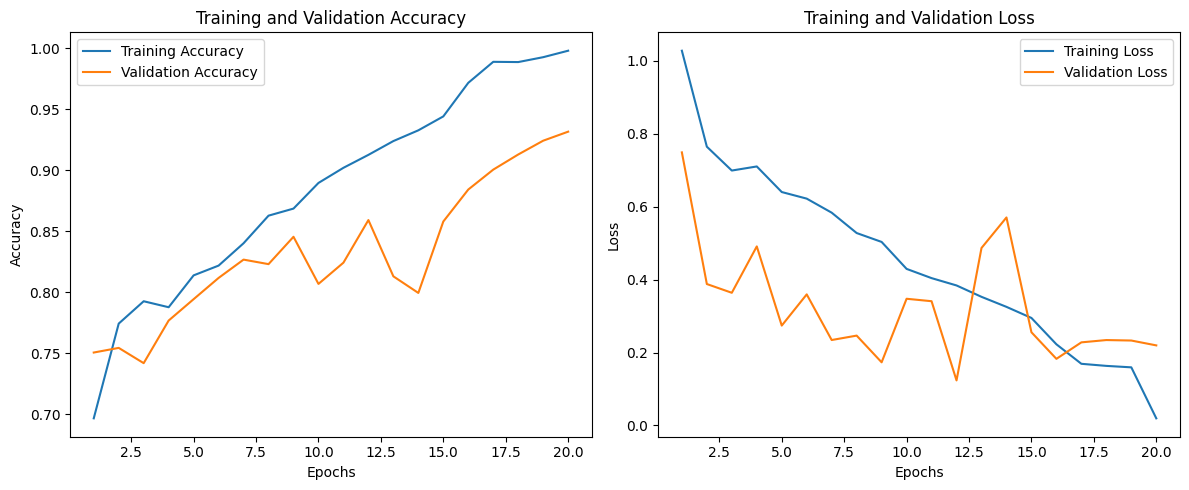

In [2]:
# Retrieving a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieving a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Getting number of epochs
epochs = range(len(acc))

# Plotting training and validation accuracy per epoch
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label="Training Accuracy")
plt.plot(epochs, val_acc, label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Plotting training and validation loss per epoch
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label="Training Loss")
plt.plot(epochs, val_loss, label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()